## Amin Aghakasiri

# SFT

### Preparation

In [ ]:
%%capture
!pip install -U "accelerate>=0.27.0"

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm==0.8.5.post1

In [ ]:
%%capture
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm==0.8.5.post1
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.19.1" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

In [ ]:
%%capture
!pip install python-dotenv

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.19.1" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from unsloth.chat_templates import train_on_responses_only
from trl import SFTTrainer, SFTConfig
from transformers import DataCollatorForSeq2Seq
import torch
from peft import LoraConfig, TaskType
from transformers import TrainingArguments
import os
from dotenv import load_dotenv
import os, torch, json, math, random, re, gc
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, accuracy_score, f1_score
from IPython.display import display
from unsloth import FastModel
from unsloth.chat_templates import get_chat_template
from unsloth.chat_templates import train_on_responses_only
from trl import GRPOConfig, GRPOTrainer
import os, torch, json, math, random, re, gc
from transformers import TextStreamer
import accelerate

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
load_dotenv()
api_key = os.getenv('HF_TOKEN')

In [ ]:
!huggingface-cli login --token $api_key

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `tokk` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

In [ ]:
train_df = pd.read_csv("train.csv", sep="\t")
dev_df   = pd.read_csv("dev.csv", sep="\t")
test_df  = pd.read_csv("test.csv", sep="\t")
for df in (train_df, dev_df, test_df):
    df["label"] = df["label"].str.lower().str.strip()

train_df.drop(columns='Unnamed: 0', inplace=True)
dev_df.drop(columns='Unnamed: 0', inplace=True)
test_df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
train_df.head(3)

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,sad,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,happy,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,sad,1


### EDA

In [ ]:
train_df.describe()

,label_id
count,56700.000000
mean,0.500000
std,0.500004
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
test_df.describe()

,label_id
count,7000.000000
mean,0.500000
std,0.500036
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
dev_df.describe()

,label_id
count,6300.00000
mean,0.50000
std,0.50004
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [ ]:
train_df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,sad,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,happy,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,sad,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,happy,0
4,شیرینی وانیلی فقط یک مدل بود.,happy,0


In [ ]:
print("----- dataset sizes -----")
print(f"Train : {len(train_df):,}")
print(f"Dev   : {len(dev_df):,}")
print(f"Test  : {len(test_df):,}")

----- dataset sizes -----
Train : 56,700
Dev   : 6,300
Test  : 7,000



===== Train split =====

Label distribution:
label
happy    28350
sad      28350


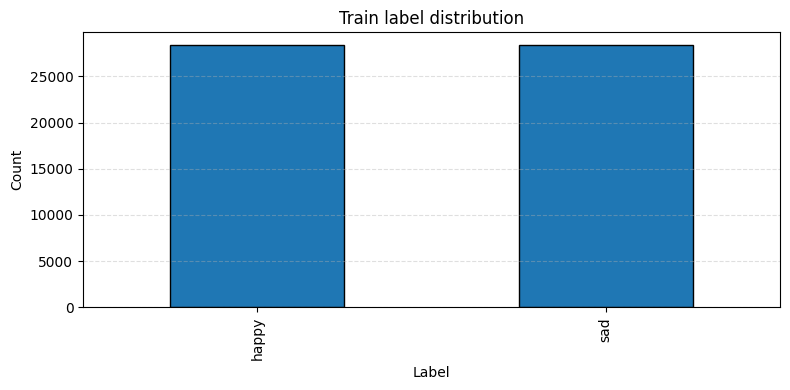


Comment length (tokens):
count    56700.000000
mean        18.613210
std         15.757905
min          4.000000
50%         14.000000
75%         23.000000
90%         38.000000
max        361.000000


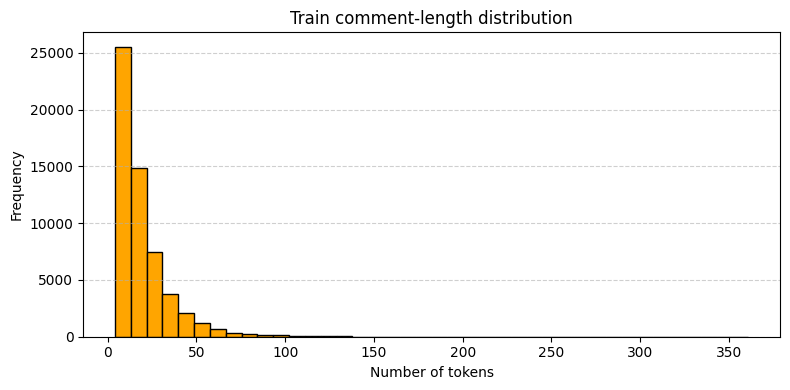


===== Dev split =====

Label distribution:
label
happy    3150
sad      3150


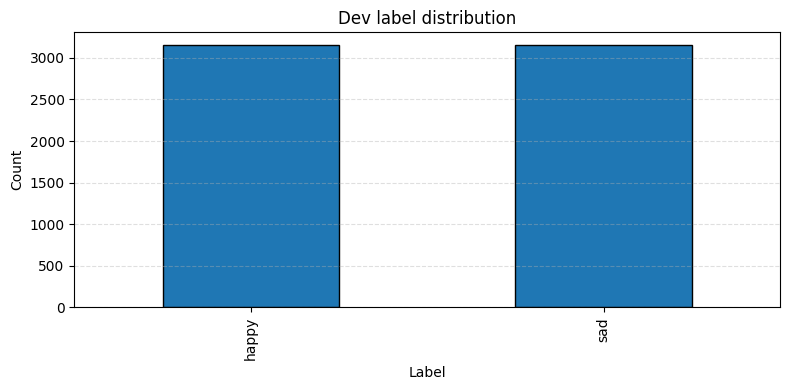


Comment length (tokens):
count    6300.000000
mean       18.788889
std        16.105508
min         4.000000
50%        14.000000
75%        24.000000
90%        37.000000
max       186.000000


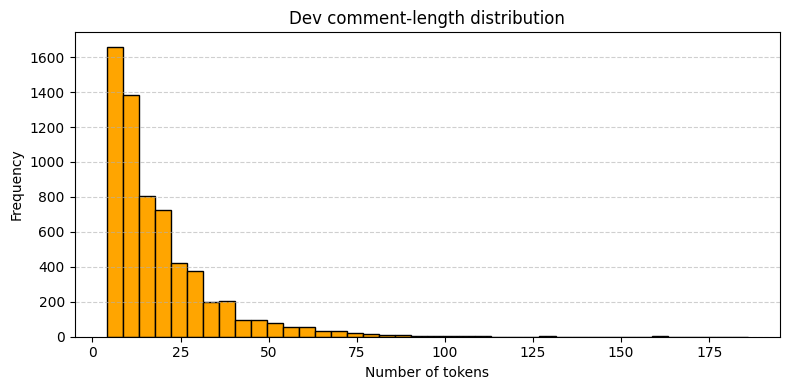


===== Test split =====

Label distribution:
label
happy    3500
sad      3500


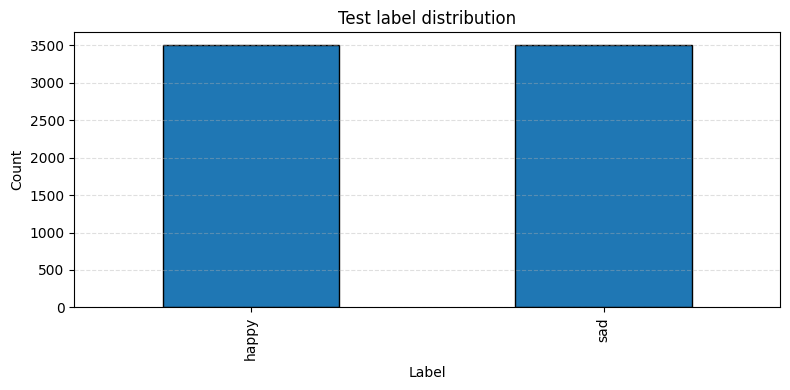


Comment length (tokens):
count    7000.000000
mean       18.847143
std        15.964753
min         4.000000
50%        14.000000
75%        24.000000
90%        38.000000
max       173.000000


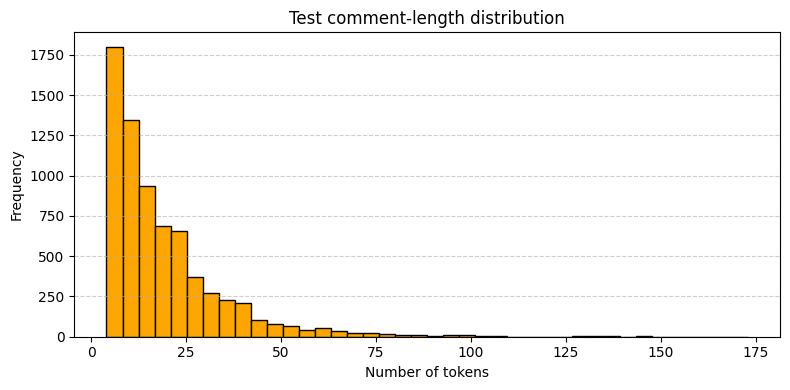

In [ ]:
def token_lens(series):
    return series.fillna("").str.split().apply(len)
for split_name, df in [("Train", train_df), ("Dev", dev_df), ("Test", test_df)]:
    print(f"\n===== {split_name} split =====")

    counts = df["label"].value_counts().sort_index()
    print("\nLabel distribution:")
    print(counts.to_string())

    plt.figure(figsize=(8,4))
    counts.plot(kind="bar", color="#1f77b4", edgecolor="black")
    plt.title(f"{split_name} label distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    lengths = token_lens(df["comment"])
    print("\nComment length (tokens):")
    print(lengths.describe(percentiles=[0.5, 0.75, 0.9]).to_string())

    plt.figure(figsize=(8,4))
    plt.hist(lengths, bins=40, color="orange", edgecolor="black")
    plt.title(f"{split_name} comment‑length distribution")
    plt.xlabel("Number of tokens")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

### Load Model

In [ ]:
model_name = "google/gemma-3-1b-it"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 2048,
    load_in_4bit = False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 30,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.model` require gradients


### Data and Prompt Preparation

In [ ]:
tokenizer = get_chat_template(tokenizer, chat_template="gemma-3")
SYSTEM_MSG = (
    "You are an expert sentiment‑analysis assistant for Persian food‑delivery "
    "customer reviews.\n\n"
    "- Read the user’s comment.\n"
    "- Decide which single overall emotion is conveyed.\n\n"
    "Valid answers (all lowercase, no punctuation or whitespace):\n\n"
    " happy ‒ the comment is overall positive, satisfied, or appreciative.\n"
    " sad ‒ the comment is overall negative, dissatisfied, or complaining.\n\n"
    "If sentiment is mixed or unclear, choose the emotion that dominates.\n"
    "Respond **with the label only** (either happy or sad); do not add anything else."
)
def formatting_func(examples):
    comments, labels = examples["comment"], examples["label"]
    conversations = [
        [
            {"role":"system",    "content": SYSTEM_MSG},
            {"role":"user",      "content": f"\n<comment>\n{c}\n</comment>"},
            {"role":"assistant", "content": l},
        ]
        for c,l in zip(comments, labels)
    ]
    texts = [tokenizer.apply_chat_template(conv, tokenize=False, add_generation_prompt=False) for conv in conversations]
    return {"text": texts}

def formatting_func_test(examples):
    comments, labels = examples["comment"], examples["label"]
    conversations = [
        [
            {"role":"system",    "content": SYSTEM_MSG},
            {"role":"user",      "content": f"\n<comment>\n{c}\n</comment>"},
            {"role":"assistant", "content": ""},
        ]
        for c,l in zip(comments, labels)
    ]
    texts = [tokenizer.apply_chat_template(conv, tokenize=False, add_generation_prompt=False) for conv in conversations]
    return {"text": texts, "label": labels}

def prep(df):
    return (Dataset.from_pandas(df, preserve_index=False).map(formatting_func, batched=True, remove_columns=list(df.columns)))

def prep_test(df):
    return (Dataset.from_pandas(df, preserve_index=False).map(formatting_func_test, batched=True, remove_columns=list(df.columns)))

train_ds = prep(train_df)
dev_ds   = prep(dev_df)
test_ds  = prep_test(test_df)

Map:   0%|          | 0/56700 [00:00<?, ? examples/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [ ]:
train_set = train_ds.train_test_split(train_size=0.1, shuffle = True, seed = 30)["train"]
test_set = test_ds.train_test_split(train_size=0.1, shuffle = True, seed = 30)["train"]
dev_set = dev_ds.train_test_split(train_size=0.1, shuffle = True, seed = 30)["train"]

In [ ]:
train_set

Dataset({
    features: ['text'],
    num_rows: 5670
})

In [ ]:
test_set

Dataset({
    features: ['label', 'text'],
    num_rows: 700
})

In [ ]:
dev_set

Dataset({
    features: ['text'],
    num_rows: 630
})

### SFT Configuration

In [ ]:
sft_conf = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1,
        max_steps = 500,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 30,
        output_dir = "gemma_sft",
        report_to = "none",
        eval_steps = 10,
        eval_strategy = "steps"
  )
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_set,
    eval_dataset = dev_set,
    dataset_text_field = "text",
    max_seq_length = 2048,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    packing = False,
    args = sft_conf
)

Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/5670 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/630 [00:00<?, ? examples/s]

### Train Model

In [ ]:
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part    = "<start_of_turn>model\n",
)

Map (num_proc=2):   0%|          | 0/5670 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/630 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

'<bos><bos><start_of_turn>user\nYou are an expert sentiment‑analysis assistant for Persian food‑delivery customer reviews.\n\n- Read the user’s comment.\n- Decide which single overall emotion is conveyed.\n\nValid answers (all lowercase, no punctuation or whitespace):\n\n happy ‒ the comment is overall positive, satisfied, or appreciative.\n sad ‒ the comment is overall negative, dissatisfied, or complaining.\n\nIf sentiment is mixed or unclear, choose the emotion that dominates.\nRespond **with the label only** (either happy or sad); do not add anything else.\n\n<comment>\nپیتزا و مرغ سوخاریتون عالیه سرویس دهی و پیکتون هم خوبه اما میگو سوخاری خیلی خیلی بد بود\n</comment><end_of_turn>\n<start_of_turn>model\nsad<end_of_turn>\n'

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,670 | Num Epochs = 1 | Total steps = 500
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 13,045,760 of 1,012,931,712 (1.29% trained)


Step,Training Loss,Validation Loss
10,0.248600,0.219763
20,0.052000,0.265771
30,0.250200,0.197463
40,0.173200,0.212841
50,0.170300,0.145593
60,0.415700,0.166152
70,0.245100,0.218718
80,0.291700,0.167243
90,0.116600,0.173369
100,0.253800,0.260578


### Save Model

In [ ]:
drive_ckpt_dir = "/content/drive/MyDrive/checkpoints/sft_sentiment_gemma3_lora"
sft_conf.output_dir = drive_ckpt_dir
trainer.args = sft_conf
trainer.save_model(drive_ckpt_dir)
tokenizer.save_pretrained(drive_ckpt_dir)
print("Everything stored in Drive: ", drive_ckpt_dir)


Everything stored in Drive:  /content/drive/MyDrive/checkpoints/sft_sentiment_gemma3_lora


In [ ]:
src  = "/content/gemma_sft"
dest = "/content/drive/MyDrive/checkpoints/sft_sentiment_gemma3_lora"

!mkdir -p "$dest"
!cp -r "$src"/* "$dest"

print("Copied to Drive: ", dest)


Copied to Drive:  /content/drive/MyDrive/checkpoints/sft_sentiment_gemma3_lora


### Evaluation

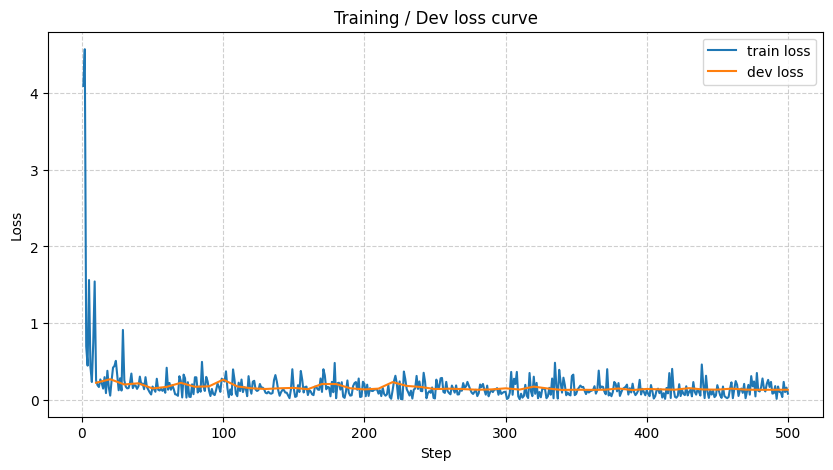

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
train_rows = logs[logs["loss"].notna()]
eval_rows  = logs[logs.get("eval_loss", pd.Series(dtype=float)).notna()]

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(train_rows["step"], train_rows["loss"], label="train loss")
if not eval_rows.empty:
    ax.plot(eval_rows["step"],  eval_rows["eval_loss"], label="dev loss")

ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.set_title("Training / Dev loss curve")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()


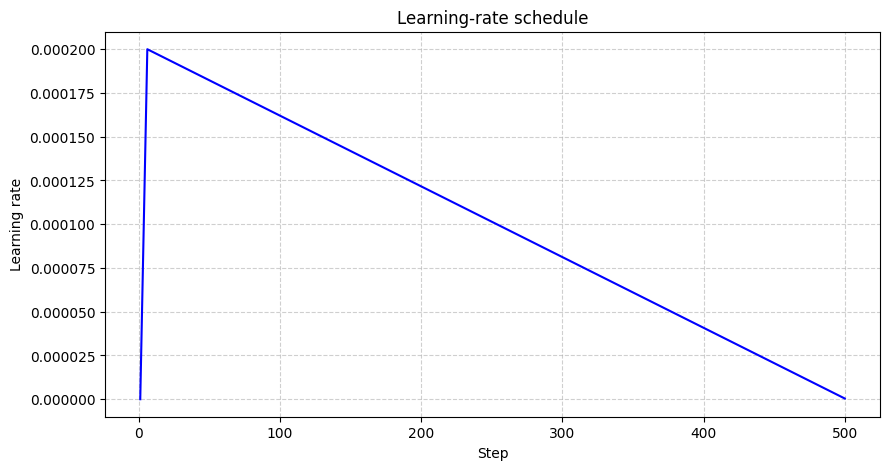

In [ ]:
lr_rows = logs[logs["learning_rate"].notna()]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lr_rows["step"], lr_rows["learning_rate"], color="blue")
ax.set_xlabel("Step")
ax.set_ylabel("Learning rate")
ax.set_title("Learning‑rate schedule")
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
def build_prompt(comment):
    conv = [
        {"role":"system", "content": SYSTEM_MSG},
        {"role":"user",   "content": f"\n\n<comment>\n{comment}\n</comment>"},
        {"role":"model",  "content": ""},
    ]
    return tokenizer.apply_chat_template(conv, tokenize=False, add_generation_prompt=True)

def evaluate(model, tokenizer, prompt):
    inputs  = tokenizer(prompt, return_tensors="pt").to(model.device)
    output  = model.generate(
        **inputs,
        pad_token_id   = tokenizer.eos_token_id,
        max_new_tokens = 1,
        do_sample      = True,
        temperature    = 0.02,
    )
    temp = (
        tokenizer.decode(output[0], skip_special_tokens=True)
        .split("model")[-1]
        .strip()
        .lower()
    )

    if temp not in {"happy", "sad"}:
        temp = random.choice(("happy", "sad"))
    return temp

def get_metrics(model, tokenizer, test_set):
    test_labels = [lbl.lower().strip() for lbl in test_set["label"]]

    preds = [
        evaluate(model, tokenizer, build_prompt(sample["text"]))
        for sample in tqdm(test_set, desc="Predicting")
    ]

    acc = accuracy_score(test_labels, preds)
    f1 = f1_score(test_labels, preds, average="macro", zero_division=0)

    print(f"\nAccuracy: {acc*100:.2f}%")
    print(f"Macro‑F1: {f1:.4f}\n")
    print("Classification report:\n")
    print(
        classification_report(
            test_labels, preds,
            labels=["sad", "happy"],
            target_names=["SAD", "HAPPY"],
            zero_division=0,
        )
    )
    return preds, test_labels, acc, f1


In [ ]:
sft_preds, sft_test_labels, sft_acc, sft_f1 = get_metrics(model, tokenizer, test_set)

Predicting:   0%|          | 0/700 [00:00<?, ?it/s]


Accuracy: 86.14%
Macro‑F1: 0.8614

Classification report:

              precision    recall  f1-score   support

         SAD       0.89      0.83      0.86       358
       HAPPY       0.83      0.90      0.86       342

    accuracy                           0.86       700
   macro avg       0.86      0.86      0.86       700
weighted avg       0.86      0.86      0.86       700



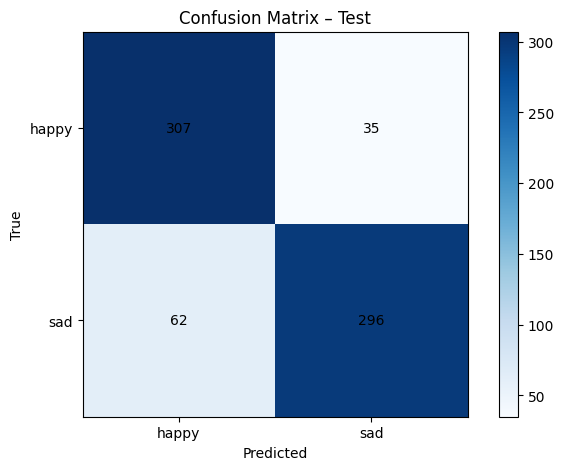

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(sft_test_labels, sft_preds, labels=["happy","sad"])
fig3, ax3 = plt.subplots(figsize=(10,5))
im = ax3.imshow(cm, cmap="Blues")
ax3.set_xticks([0,1], labels=["happy","sad"])
ax3.set_yticks([0,1], labels=["happy","sad"])
ax3.set_xlabel("Predicted")
ax3.set_ylabel("True")
ax3.set_title("Confusion Matrix – Test")
for i in range(2):
    for j in range(2):
        ax3.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.colorbar(im, ax=ax3, fraction=0.05, pad=0.04)
plt.show()

### Base Model Evaluation

In [ ]:
model_name = "google/gemma-3-1b-it"
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 2048,
    load_in_4bit = False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


In [ ]:
base_preds, base_test_labels, base_acc, base_f1 = get_metrics(base_model, tokenizer, test_set)

Predicting:   0%|          | 0/700 [00:00<?, ?it/s]


Accuracy: 78.71%
Macro‑F1: 0.7814

Classification report:

              precision    recall  f1-score   support

         SAD       0.73      0.93      0.82       358
       HAPPY       0.89      0.64      0.75       342

    accuracy                           0.79       700
   macro avg       0.81      0.78      0.78       700
weighted avg       0.81      0.79      0.78       700



In [ ]:
def print_misclasified(preds, test_labels,n_show=5):
    mismatch_idx = [i for i, (p, g) in enumerate(zip(preds, test_labels)) if p != g]
    errors_df = (
        test_df.iloc[mismatch_idx]
              .reset_index(drop=True)
              .assign(
                  true_label = [test_labels[i] for i in mismatch_idx],
                  pred_label = [preds[i]       for i in mismatch_idx]
              )[["comment", "true_label", "pred_label"]]
    )

    print(f"Total mis‑classifications: {len(errors_df):,}")
    display(errors_df.head(n_show))


In [ ]:
# Base model misclasifications
print_misclasified(base_preds, base_test_labels)

Total mis‑classifications: 149


,comment,true_label,pred_label
0,پیراشکی بندری نونش گرم‌ بود موادش سرد سرد بود ...,happy,sad
1,سرد و با تاخیر دستم رسید، محتویاتش هم بسیار کم...,happy,sad
2,در کل خوب بود. آورین,happy,sad
3,کیفیت غذا خوب بود. فقط حدود یک ساعت طول کشید ت...,happy,sad
4,من خمیر پیتزا با طمع سیر میخواستم برای من خمیر...,happy,sad


In [ ]:
# SFT model misclasifications
print_misclasified(sft_preds, sft_test_labels)

Total mis‑classifications: 97


,comment,true_label,pred_label
0,طبق توضیحاتم همون طور که خواستم فرستاده بودن خ...,sad,happy
1,برای سرعت ارسال سپاسگزارم,sad,happy
2,در کل خوب بود. آورین,happy,sad
3,عکس رولت وانیلی اصلا مطابق شیرینی ارسالی نبود,sad,happy
4,چیزکیک اندازه ش نصف یک قاچ معمول بود و بسیار ک...,happy,sad


# GRPO

### Data and Prompt Preparation

In [ ]:
train_dataset = load_dataset('csv', data_files='train.csv', split='train', delimiter='\t')
dev_dataset = load_dataset('csv', data_files='dev.csv', split='train', delimiter='\t')
test_dataset = load_dataset('csv', data_files='test.csv', split='train', delimiter='\t')

print("Datasets loaded successfully:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Dev dataset size: {len(dev_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Datasets loaded successfully:
Train dataset size: 56700
Dev dataset size: 6300
Test dataset size: 7000


In [ ]:
train_dataset

Dataset({
    features: ['Unnamed: 0', 'comment', 'label', 'label_id'],
    num_rows: 56700
})

In [ ]:
train_dataset = train_dataset.remove_columns('Unnamed: 0')
dev_dataset= dev_dataset.remove_columns('Unnamed: 0')
test_dataset = test_dataset.remove_columns('Unnamed: 0')

In [ ]:
train_dataset = train_dataset.train_test_split(train_size=0.05, shuffle = True, seed = 30)["train"]
test_dataset = test_dataset.train_test_split(train_size=0.1, shuffle = True, seed = 30)["train"]
dev_dataset = dev_dataset.train_test_split(train_size=0.005, shuffle = True, seed = 30)["train"]

In [ ]:
test_dataset = test_dataset.train_test_split(train_size=0.15, shuffle = True, seed = 30)["train"]

In [ ]:
train_dataset

Dataset({
    features: ['comment', 'label', 'label_id'],
    num_rows: 2835
})

In [ ]:
dev_dataset

Dataset({
    features: ['comment', 'label', 'label_id'],
    num_rows: 31
})

In [ ]:
test_dataset

Dataset({
    features: ['comment', 'label', 'label_id'],
    num_rows: 105
})

In [ ]:
REASONING_START = "<reasoning>"
REASONING_END = "</reasoning>"
ANSWER_START = "<answer>"
ANSWER_END = "</answer>"
POSITIVE_LABEL = "HAPPY"
NEGATIVE_LABEL = "SAD"

SYSTEM_PROMPT = f"""You are an expert sentiment analysis assistant for Persian food reviews.
Analyze the user's review and provide a step-by-step reasoning for your conclusion.
Place your reasoning between the {REASONING_START} and {REASONING_END} tags.
Your reasoning should be 1 to 5 lines long (maximum 50 words).
Finally, provide the final sentiment classification ({POSITIVE_LABEL} or {NEGATIVE_LABEL}) between the {ANSWER_START} and {ANSWER_END} tags.
Notice that there should be only label (either **happy** or **sad**) between {ANSWER_START} and {ANSWER_END} tags and nothing else between them.
Notice that your response must only contain {REASONING_START} reasoning...(maximum 50 words) {REASONING_END} and then {ANSWER_START} happy/sad {ANSWER_END}
with nothing else (for example it's no need to say 'okay let's...' at first of your response)"""

In [ ]:
def format_dataset_for_reward_tuning(dataset):
    return dataset.map(
        lambda x: {
            "prompt": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": x["comment"]},
            ],
            "answer": x["label"],
        },
        remove_columns=dataset.column_names
    )

train_reward_dataset = format_dataset_for_reward_tuning(train_dataset)
dev_reward_dataset = format_dataset_for_reward_tuning(dev_dataset)

Map:   0%|          | 0/2835 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

In [ ]:
print(train_reward_dataset[0])

{'prompt': [{'content': "You are an expert sentiment analysis assistant for Persian food reviews.\nAnalyze the user's review and provide a step-by-step reasoning for your conclusion.\nPlace your reasoning between the <reasoning> and </reasoning> tags.\nYour reasoning should be 1 to 5 lines long (maximum 50 words).\nFinally, provide the final sentiment classification (HAPPY or SAD) between the <answer> and </answer> tags.\nNotice that there should be only label (either **happy** or **sad**) between <answer> and </answer> tags and nothing else between them.\nNotice that your response must only contain <reasoning> reasoning...(maximum 50 words) </reasoning> and then <answer> happy/sad </answer>\nwith nothing else (for example it's no need to say 'okay let's...' at first of your response)", 'role': 'system'}, {'content': 'خوزمزس و تازه ولی سرد رسید!!! و اینکه قبلا رو سفارشاتون یه پک ۳ تایی سوس میزاشتین اگه نخریم هیچی دیگه!!!', 'role': 'user'}], 'answer': 'HAPPY'}


### Base Model Prompt Testing

In [ ]:
max_seq_length = 512
base_model, base_tokenizer = FastModel.from_pretrained(
    model_name="unsloth/gemma-3-1b-it",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    full_finetuning = False,
    load_in_8bit    = False,
)
sample_review = "من کلی صبر کردم اما نیومد"
messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": sample_review},
]
prompt_text = base_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.0. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


In [ ]:
inputs = base_tokenizer(prompt_text, return_tensors="pt").to(base_model.device)
streamer = TextStreamer(base_tokenizer, skip_prompt=True)
_ = base_model.generate(**inputs, streamer=streamer, max_new_tokens=200, use_cache=True)

<reasoning>The review expresses frustration and disappointment – the food was unsatisfactory and unfulfilled expectations. This indicates sadness and dissatisfaction. </reasoning>
<answer>sad</answer><end_of_turn>


### Reward Functions

In [ ]:
def reward_correct_answer(prompts, completions, answer, **kwargs):
    scores = []
    for completion, true_answer in zip(completions, answer):
        score = 0.0
        response_text = completion[0]["content"]
        pattern = re.compile(
        r"<answer>.*?\b(?P<feeling>sad|happy)\b",
        flags=re.IGNORECASE | re.DOTALL
        )
        match_answer = pattern.search(response_text)
        if match_answer:
            extracted_answer = match_answer.group("feeling").strip().upper()
            if extracted_answer == true_answer.upper():
                score += 20
            else:
                score -= 20
        else:
            score -= 10
        scores.append(score)
    return scores

def reward_words_num(prompts, completions, answer, **kwargs):
    scores = []
    for completion in completions:
        response_text = completion[0]["content"]
        pattern = re.compile(
            r"<reasoning>([^<]+)</reasoning>(?!.*<reasoning>)",
            re.DOTALL
        )
        m = pattern.search(response_text)
        if m:
            last_answer = m.group(1)
            words_list = last_answer.split()
            if(len(words_list) <= 55):
              scores.append(10)
            else:
              scores.append(-5)
        else:
            scores.append(-10)
    return scores

def reward_format(prompts, completions, answer, **kwargs):
    scores = []
    for completion in completions:
        score = 0.0
        response_text = completion[0]["content"]
        score += 5 if response_text.count(REASONING_START) <= 2 else -5
        score += 5 if response_text.count(REASONING_END) <= 2 else -5
        score += 5 if response_text.count(ANSWER_START) <= 2 else -5
        score += 5 if response_text.count(ANSWER_END) <= 2 else -5
        scores.append(score)
    return scores

### Load Model

In [ ]:
max_seq_length = 512
grpo_model, grpo_tokenizer = FastModel.from_pretrained(
    model_name="unsloth/gemma-3-1b-it",
    max_seq_length=max_seq_length,
    load_in_4bit = True,
    load_in_8bit    = False,
    full_finetuning = False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.0. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


### GRPO Config

In [ ]:
grpo_model = FastModel.get_peft_model(
    grpo_model,
    finetune_vision_layers     = False,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,
    r = 8,
    lora_alpha = 8,
    lora_dropout = 0,
    bias = "none",
    random_state = 30
)

Unsloth: Making `model.base_model.model.model` require gradients


In [ ]:
max_prompt_length = 300
training_args = GRPOConfig(
    learning_rate=1e-5,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_generations=2,
    max_prompt_length=max_prompt_length,
    max_completion_length=max_seq_length - max_prompt_length,
    max_steps=160,
    save_steps=5,
    logging_steps=5,
    output_dir="gemma_grpo",
    optim="adamw_torch_fused",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    remove_unused_columns=False,
    report_to  = "none",
)

trainer = GRPOTrainer(
    model=grpo_model,
    processor=grpo_tokenizer,
    reward_funcs=[
        reward_correct_answer,
        reward_words_num,
        reward_format
    ],
    args=training_args,
    train_dataset= train_reward_dataset,
)

Unsloth: Switching to float32 training since model cannot work with float16


### Train Model

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,835 | Num Epochs = 1 | Total steps = 160
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 6,522,880 of 1,006,408,832 (0.65% trained)


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / reward_correct_answer / mean,rewards / reward_correct_answer / std,rewards / reward_words_num / mean,rewards / reward_words_num / std,rewards / reward_format / mean,rewards / reward_format / std
5,0.000000,39.250000,3.535534,47.962500,28.400000,79.200000,0.000000,47.962500,28.400000,79.200000,0.000019,12.250000,13.622607,7.000000,6.069969,20.000000,0.000000
10,0.000000,36.750000,5.656854,44.162500,29.000000,64.600000,0.000000,44.162500,29.000000,64.600000,0.000037,9.250000,12.359619,7.500000,6.591163,20.000000,0.000000
15,0.000000,35.250000,2.474874,45.537500,32.600000,83.600000,0.000000,45.537500,32.600000,83.600000,0.000268,7.000000,18.490430,8.250000,3.281114,20.000000,0.000000
20,0.000000,35.250000,2.474874,46.937500,36.000000,74.400000,0.000000,46.937500,36.000000,74.400000,0.002553,6.500000,18.219788,8.750000,4.366260,20.000000,0.000000
25,0.000000,40.000000,1.414214,45.162500,15.600000,96.200000,0.012500,43.100001,15.600000,67.000000,0.005695,12.000000,13.100781,8.000000,5.465041,20.000000,0.000000
30,0.000000,36.500000,3.181981,45.500000,29.200000,61.400000,0.000000,45.500000,29.200000,61.400000,0.005148,7.250000,18.556604,9.250000,2.366260,20.000000,0.000000
35,0.000000,39.750000,1.060660,44.275000,30.000000,62.400000,0.000000,44.275000,30.000000,62.400000,0.013319,11.000000,16.071282,8.750000,3.732520,20.000000,0.000000
40,0.000000,40.750000,1.767767,44.800000,37.200000,60.200000,0.000000,44.800000,37.200000,60.200000,0.009963,11.000000,16.760035,9.750000,1.000000,20.000000,0.000000
45,0.000000,39.125000,1.944544,43.700000,24.000000,78.600000,0.000000,43.700000,24.000000,78.600000,0.009715,10.625000,16.373173,8.500000,4.098780,20.000000,0.000000
50,0.000000,41.500000,0.707107,43.562500,35.600000,54.200000,0.000000,43.562500,35.600000,54.200000,0.010409,11.500000,15.553646,10.000000,0.000000,20.000000,0.000000


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / reward_correct_answer / mean,rewards / reward_correct_answer / std,rewards / reward_words_num / mean,rewards / reward_words_num / std,rewards / reward_format / mean,rewards / reward_format / std
5,0.000000,39.250000,3.535534,47.962500,28.400000,79.200000,0.000000,47.962500,28.400000,79.200000,0.000019,12.250000,13.622607,7.000000,6.069969,20.000000,0.000000
10,0.000000,36.750000,5.656854,44.162500,29.000000,64.600000,0.000000,44.162500,29.000000,64.600000,0.000037,9.250000,12.359619,7.500000,6.591163,20.000000,0.000000
15,0.000000,35.250000,2.474874,45.537500,32.600000,83.600000,0.000000,45.537500,32.600000,83.600000,0.000268,7.000000,18.490430,8.250000,3.281114,20.000000,0.000000
20,0.000000,35.250000,2.474874,46.937500,36.000000,74.400000,0.000000,46.937500,36.000000,74.400000,0.002553,6.500000,18.219788,8.750000,4.366260,20.000000,0.000000
25,0.000000,40.000000,1.414214,45.162500,15.600000,96.200000,0.012500,43.100001,15.600000,67.000000,0.005695,12.000000,13.100781,8.000000,5.465041,20.000000,0.000000
30,0.000000,36.500000,3.181981,45.500000,29.200000,61.400000,0.000000,45.500000,29.200000,61.400000,0.005148,7.250000,18.556604,9.250000,2.366260,20.000000,0.000000
35,0.000000,39.750000,1.060660,44.275000,30.000000,62.400000,0.000000,44.275000,30.000000,62.400000,0.013319,11.000000,16.071282,8.750000,3.732520,20.000000,0.000000
40,0.000000,40.750000,1.767767,44.800000,37.200000,60.200000,0.000000,44.800000,37.200000,60.200000,0.009963,11.000000,16.760035,9.750000,1.000000,20.000000,0.000000
45,0.000000,39.125000,1.944544,43.700000,24.000000,78.600000,0.000000,43.700000,24.000000,78.600000,0.009715,10.625000,16.373173,8.500000,4.098780,20.000000,0.000000
50,0.000000,41.500000,0.707107,43.562500,35.600000,54.200000,0.000000,43.562500,35.600000,54.200000,0.010409,11.500000,15.553646,10.000000,0.000000,20.000000,0.000000


TrainOutput(global_step=160, training_loss=1.5572526613993887e-05, metrics={'train_runtime': 2898.5184, 'train_samples_per_second': 0.883, 'train_steps_per_second': 0.055, 'total_flos': 0.0, 'train_loss': 1.5572526613993887e-05})

In [ ]:
test_dataset

Dataset({
    features: ['comment', 'label', 'label_id'],
    num_rows: 105
})

In [ ]:
model_path = "/content/drive/MyDrive/checkpoints/grpo_sentiment_gemma3_lora"
loaded_model, loaded_tokenizer = FastModel.from_pretrained(
    model_name = model_path,
    max_seq_length = 512,
    load_in_4bit = True,
    load_in_8bit    = False,
    full_finetuning = False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.0. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


In [ ]:
max_seq_length = 512
max_prompt_length = 300
training_args = GRPOConfig(
    learning_rate=1e-5,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    num_generations=2,
    max_prompt_length=max_prompt_length,
    max_completion_length=max_seq_length - max_prompt_length,
    max_steps=10,
    save_steps=5,
    logging_steps=5,
    output_dir="temp_loaded",
    optim="adamw_torch_fused",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    remove_unused_columns=False,
    report_to  = "none",
    eval_steps = 1,
    eval_strategy = "steps"
)

trainer = GRPOTrainer(
    model=loaded_model,
    processor=loaded_tokenizer,
    reward_funcs=[
        reward_correct_answer,
        reward_words_num,
        reward_format
    ],
    args=training_args,
    train_dataset= train_reward_dataset,
    eval_dataset = dev_reward_dataset,
)

Unsloth: Switching to float32 training since model cannot work with float16


In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,835 | Num Epochs = 1 | Total steps = 10
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 6,522,880 of 1,006,408,832 (0.65% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 32768, 'top_p': 0.95}. If this is not desired, please set these values explicitly.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / reward_correct_answer / mean,rewards / reward_correct_answer / std,rewards / reward_words_num / mean,rewards / reward_words_num / std,rewards / reward_format / mean,rewards / reward_format / std
1,No log,0.000008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,No log,0.000019,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
3,No log,0.000009,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
4,No log,0.000014,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
5,0.000000,0.000009,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
6,0.000000,-0.005598,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
7,0.000000,0.000007,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
8,0.000000,0.000010,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log


Step,Training Loss,Validation Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / reward_correct_answer / mean,rewards / reward_correct_answer / std,rewards / reward_words_num / mean,rewards / reward_words_num / std,rewards / reward_format / mean,rewards / reward_format / std
1,No log,0.000008,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,No log,0.000019,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
3,No log,0.000009,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
4,No log,0.000014,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
5,0.000000,0.000009,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
6,0.000000,-0.005598,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
7,0.000000,0.000007,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
8,0.000000,0.000010,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
9,0.000000,0.000008,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
10,0.000000,0.005629,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log


TrainOutput(global_step=10, training_loss=1.782219624146819e-05, metrics={'train_runtime': 1486.6123, 'train_samples_per_second': 0.108, 'train_steps_per_second': 0.007, 'total_flos': 0.0, 'train_loss': 1.782219624146819e-05})

### Save Model

In [ ]:
drive_ckpt_dir = "/content/drive/MyDrive/checkpoints/grpo_sentiment_gemma3_lora"
training_args.output_dir = drive_ckpt_dir
trainer.args = training_args
trainer.save_model(drive_ckpt_dir)
grpo_tokenizer.save_pretrained(drive_ckpt_dir)
print("Everything stored in Drive: ", drive_ckpt_dir)


Everything stored in Drive:  /content/drive/MyDrive/checkpoints/grpo_sentiment_gemma3_lora


In [ ]:
src  = "/content/gemma_grpo"
dest = "/content/drive/MyDrive/checkpoints/grpo_sentiment_gemma3_lora"

!mkdir -p "$dest"
!cp -r "$src"/* "$dest"

print("Copied to Drive: ", dest)


Copied to Drive:  /content/drive/MyDrive/checkpoints/grpo_sentiment_gemma3_lora


### Evaluation

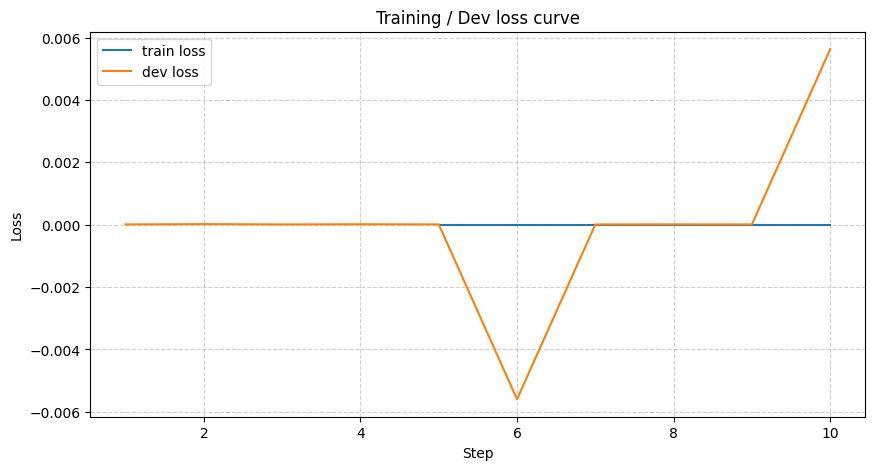

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)

train_rows = logs[logs["loss"].notna()]
eval_rows  = logs[logs.get("eval_loss", pd.Series(dtype=float)).notna()]

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(train_rows["step"], train_rows["loss"], label="train loss")
if not eval_rows.empty:
    ax.plot(eval_rows["step"],  eval_rows["eval_loss"], label="dev loss")

ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.set_title("Training / Dev loss curve")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()


In RL, Loss = Negative of the Reward Objective. The goal in RL is to maximize a reward and thus negative loss above in step 6, means that during that evaluation step, the model generated responses that had a very high positive advantage and it produced some high reward answers, which made the -(advantage) term negative.

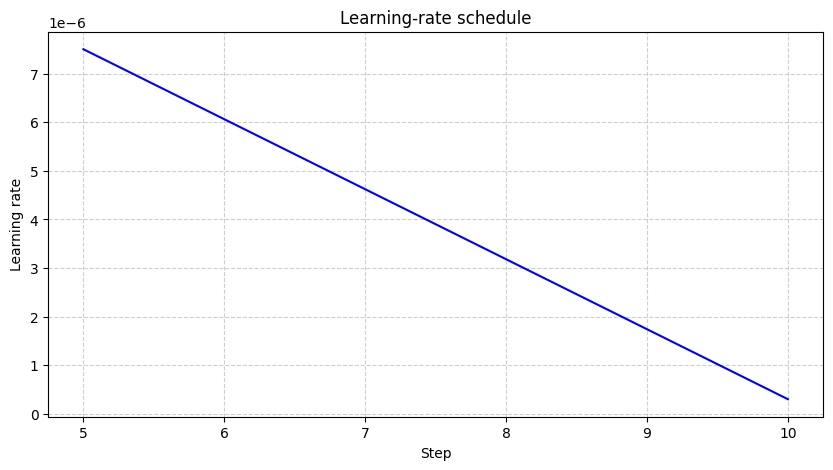

In [ ]:
lr_rows = logs[logs["learning_rate"].notna()]
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lr_rows["step"], lr_rows["learning_rate"], color="blue")
ax.set_xlabel("Step")
ax.set_ylabel("Learning rate")
ax.set_title("Learning‑rate schedule")
ax.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
eval_model = loaded_model
eval_tokenizer = loaded_tokenizer
y_true = []
y_pred = []
test_df = test_dataset.to_pandas()

In [ ]:
test_df

,comment,label,label_id
0,دوستان زحمت کشیدن بعد از یک ساعت و نیم و کلی پ...,SAD,1
1,غذا گرم بود. فقط کوچیک بود بنظرم,HAPPY,0
2,به معنای واقعی بد,SAD,1
3,خیلی خوبه با پشتیبانی عالی,HAPPY,0
4,فقط پیتزاها خنک به دستمان رسید.,HAPPY,0
...,...,...,...
100,سرعت ارسال غذا عالی بود اما مرغ‌ها اصلا مزه‌ای...,SAD,1
101,خوشمزه بود فقط سالاد کلم مزه خوبی نمیداد,HAPPY,0
102,تنها حسنی که داشت زود رسید. تو توضیحات هم نوشت...,HAPPY,0
103,در کل راضی بودم. گرچه به نظرم کوبیده هاتون خیل...,HAPPY,0


In [ ]:
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
    comment = row['comment']
    true_label = row['label']

    if not isinstance(comment, str) or not comment.strip() or not isinstance(true_label, str):
        continue

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": comment},
    ]

    prompt_text = eval_tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False,
    )

    inputs = eval_tokenizer(prompt_text, return_tensors="pt").to(eval_model.device)
    outputs = eval_model.generate(**inputs, max_new_tokens=200, use_cache=True, do_sample=False)
    response_text = eval_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    generated_part = response_text[len(prompt_text):]
    pattern = re.compile(
        r"<answer>.*?\b(?P<feeling>sad|happy)\b",
        flags=re.IGNORECASE | re.DOTALL
        )
    m = pattern.search(generated_part)
    prediction = m.group("feeling").strip().upper() if m else random.choice(("HAPPY", "SAD"))
    y_true.append(true_label.upper())
    y_pred.append(prediction if prediction else "N/A")


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
grpo_acc = accuracy_score(y_true, y_pred)
grpo_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("\n--- Evaluation Results ---")
print(f"Total Test Samples Evaluated: {len(y_true)}")
print(f"Accuracy: {grpo_acc*100:.4f}%")
print(f"F1-Score (Macro): {grpo_f1:.4f}")
print("\nClassification Report:")
labels = sorted(list(set(y_true + y_pred)))
print(classification_report(y_true, y_pred, labels=labels, zero_division=0))


--- Evaluation Results ---
Total Test Samples Evaluated: 105
Accuracy: 80.0000%
F1-Score (Macro): 0.7939

Classification Report:
              precision    recall  f1-score   support

       HAPPY       0.85      0.69      0.76        48
         SAD       0.77      0.89      0.83        57

    accuracy                           0.80       105
   macro avg       0.81      0.79      0.79       105
weighted avg       0.81      0.80      0.80       105



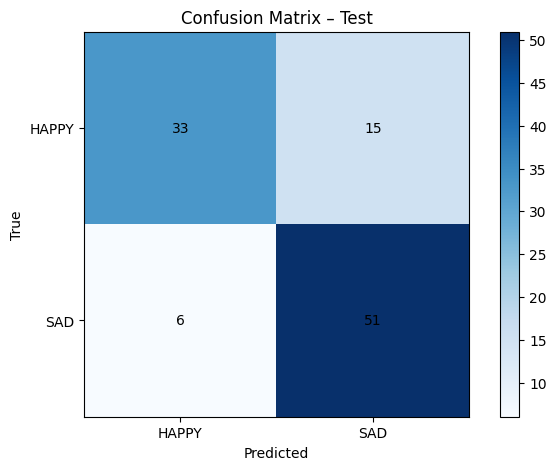

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=["HAPPY","SAD"])
fig3, ax3 = plt.subplots(figsize=(10,5))
im = ax3.imshow(cm, cmap="Blues")
ax3.set_xticks([0,1], labels=["HAPPY","SAD"])
ax3.set_yticks([0,1], labels=["HAPPY","SAD"])
ax3.set_xlabel("Predicted")
ax3.set_ylabel("True")
ax3.set_title("Confusion Matrix – Test")
for i in range(2):
    for j in range(2):
        ax3.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.colorbar(im, ax=ax3, fraction=0.05, pad=0.04)
plt.show()

### Some Examples of Generations

In [ ]:
for index, row in test_df.iloc[15:25].iterrows():
    comment = row['comment']
    true_label = row['label']

    if not isinstance(comment, str) or not comment.strip() or not isinstance(true_label, str):
        continue

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": comment},
    ]

    prompt_text = eval_tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False,
    )

    inputs = eval_tokenizer(prompt_text, return_tensors="pt").to(eval_model.device)
    outputs = eval_model.generate(**inputs, max_new_tokens=200, use_cache=True, do_sample=False)
    response_text = eval_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    print(f"Prompt and Response:\n\n{response_text}\n")
    print(f"Test Label: {true_label}")

Prompt and Response:

user
You are an expert sentiment analysis assistant for Persian food reviews.
Analyze the user's review and provide a step-by-step reasoning for your conclusion.
Place your reasoning between the <reasoning> and </reasoning> tags.
Your reasoning should be 1 to 5 lines long (maximum 50 words).
Finally, provide the final sentiment classification (HAPPY or SAD) between the <answer> and </answer> tags.
Notice that there should be only label (either **happy** or **sad**) between <answer> and </answer> tags and nothing else between them.
Notice that your response must only contain <reasoning> reasoning...(maximum 50 words) </reasoning> and then <answer> happy/sad </answer>
with nothing else (for example it's no need to say 'okay let's...' at first of your response)

فیله مرغ رژیمی خیلی خوب نپخته بود و مزه خامی می‌داد.
model
<reasoning>The review expresses dissatisfaction with the meat quality – it was poorly prepared and had a bitter taste. This clearly indicates a negat

### Base vs SFT vs GRPO

In [ ]:
def plot_base_vs_tuned(base_acc, base_f1, sft_acc, sft_f1, grpo_acc, grpo_f1):
    labels = ["Base-Acc", "SFT-Acc", "GRPO-Acc", "Base-F1", "SFT-F1", "GRPO-F1"]
    values = [base_acc, sft_acc, grpo_acc, base_f1, sft_f1, grpo_f1]
    colors = ["yellow"]*3 + ["green"]*3
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(x, values, color=colors, edgecolor="black")
    ax.set_xticks(x, labels, rotation=45, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Score")
    ax.set_title("Base vs SFT vs GRPO")
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f"{v:.1%}", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()

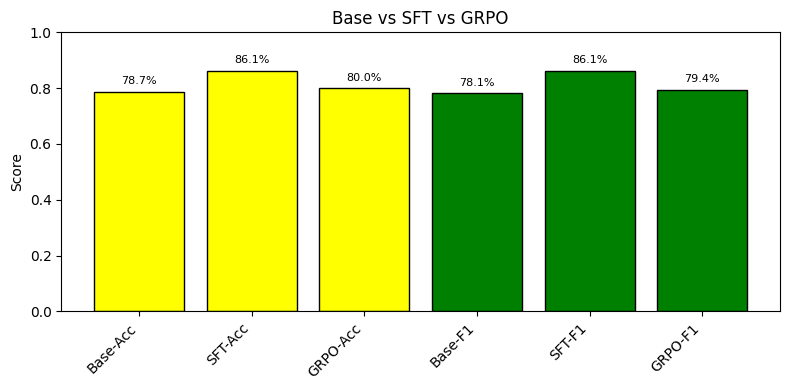

In [ ]:
plot_base_vs_tuned(base_acc, base_f1, sft_acc, sft_f1, grpo_acc, grpo_f1)

As we can see above, the SFT works better from that two. GRPO wasn't as good as SFT in this task because it is a sentiment task and there isn't much capabillity for working on reasoning part and reward the model based on that and therefore, here SFT worked better (however, if we have more resources and time, we can train GRPO much more to get the rewards better and train better and then maybe it becomes better than SFT). Also for running with more steps for GRPO part, we need much more computation resource because of the text generation part for each sample.

# AIME Dataset Test

### Preparation

In [ ]:
from unsloth import FastModel
import os
import re
import torch
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [ ]:
aime_dataset = load_dataset("Maxwell-Jia/AIME_2024", split="train")

README.md: 0.00B [00:00, ?B/s]

aime_2024_problems.parquet:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
aime_dataset

Dataset({
    features: ['ID', 'Problem', 'Solution', 'Answer'],
    num_rows: 30
})

In [ ]:
REASONING_START = "<reasoning>"
REASONING_END = "</reasoning>"
ANSWER_START = "<answer>"
ANSWER_END = "</answer>"

MATH_SYSTEM_PROMPT = f"""You are a brilliant mathematician. Solve the following math problem.
First, think step-by-step and write down your reasoning process inside the {REASONING_START} and {REASONING_END} tags.
Finally, provide only the final numerical answer inside the {ANSWER_START} and {ANSWER_END} tags. The final answer must be a non-negative integer.
Your whole reasoning **mustn't** be more than **2000** tokens and you must give the final numerical answer after this(pay attention to this)!"""

In [ ]:
def extract_answer(model_output):
    matched_txt = re.search(r'(\d+)(?!.*\d)', model_output, re.DOTALL)
    if not matched_txt:
        return False, None
    num = int(matched_txt.group())
    if not num:
        return True, None
    return True, num

In [ ]:
def evaluate_aime(aime_model, aime_tokenizer):
  print("\nStarting evaluation on AIME 2024 test set...")
  prompts = []
  y_true_aime = []
  for problem_data in aime_dataset:
      problem_text = problem_data['Problem']
      true_answer = str(problem_data['Answer'])

      if not isinstance(problem_text, str) or not problem_text.strip():
          continue

      messages = [
          {"role": "system", "content": MATH_SYSTEM_PROMPT},
          {"role": "user", "content": problem_text},
      ]

      prompts.append(
          aime_tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
      )
      y_true_aime.append(true_answer)

  batch_size = 32
  y_pred_aime = []
  results_for_df = []

  for i in tqdm(range(0, len(prompts), batch_size), desc="Evaluating AIME in Batches"):
      batch_prompts = prompts[i:i+batch_size]
      batch_true_answers = y_true_aime[i:i+batch_size]
      inputs = aime_tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True, padding_side = "left").to(aime_model.device)
      outputs = aime_model.generate(**inputs, max_new_tokens=4000, use_cache=True, do_sample=False)
      decoded_outputs = aime_tokenizer.batch_decode(outputs, skip_special_tokens=True)

      for j, decoded_output in enumerate(decoded_outputs):
          prompt_length = len(batch_prompts[j])
          generated_part = decoded_output[prompt_length:]

          format_ok, extracted_answer = extract_answer(generated_part)

          current_true_answer = batch_true_answers[j]
          y_pred_aime.append(extracted_answer if extracted_answer is not None else "Extraction_Failed")

          results_for_df.append({
              "problem": batch_prompts[j][:100] + "...",
              "true_answer": current_true_answer,
              "extracted_answer": extracted_answer,
          })
  return y_true_aime, y_pred_aime, results_for_df


In [44]:
def get_aime_metrics(y_true_aime_grpo, y_pred_aime_grpo, results_for_df):
    accuracy = accuracy_score(y_true_aime_grpo, y_pred_aime_grpo)
    f1_macro = f1_score(y_true_aime_grpo, y_pred_aime_grpo, average='macro', zero_division=0)
    print(f"Total Problems Evaluated: {len(y_true_aime_grpo)}")
    print("-" * 40)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print("-" * 40)

    print("\nDetailed Results:")
    results_df = pd.DataFrame(results_for_df)
    pd.set_option('display.float_format', lambda x: '%.0f' % x)
    pd.set_option('display.max_colwidth', 400)
    print(results_df.head(30)[['true_answer', 'extracted_answer']])

## Base Model

### Load Model

In [52]:
model_name = "google/gemma-3-1b-it"
aime_base_model, aime_base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = 4000,
    load_in_4bit = False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


### Evaluate

In [53]:
y_true_aime_base, y_pred_aime_base, results_base = evaluate_aime(aime_base_model, aime_base_tokenizer)


Starting evaluation on AIME 2024 test set...


Evaluating AIME in Batches: 100%|██████████| 1/1 [11:48<00:00, 708.70s/it]


### Results

In [54]:
y_pred_aime_base = [str(x) for x in y_pred_aime_base]

In [56]:
get_aime_metrics(y_true_aime_base, y_pred_aime_base, results_base)

Total Problems Evaluated: 30
----------------------------------------
Accuracy: 0.0000
F1-Score (Macro): 0.0000
----------------------------------------

Detailed Results:
   true_answer  extracted_answer
0           33                 4
1           23                 5
2          116                 7
3          809               134
4          197             11272
5          385                 2
6          371                 1
7          601           6000000
8           25               128
9           55           2049300
10         540               324
11          45               999
12         204             15840
13         699              9997
14         294               910
15         110                10
16         721                24
17         315                66
18         468                84
19         902             53130
20         211                 9
21          80               300
22         480                 2
23         236               194
24 

## SFT Model

### Load Model

In [46]:
from unsloth import FastLanguageModel
model_path = "/content/drive/MyDrive/checkpoints/sft_sentiment_gemma3_lora"
aime_sft_model, aime_sft_tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_path,
    max_seq_length = 4000,
    load_in_4bit = False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

### Evaluate

In [47]:
y_true_aime_sft, y_pred_aime_sft, results_sft = evaluate_aime(aime_sft_model, aime_sft_tokenizer)


Starting evaluation on AIME 2024 test set...


Evaluating AIME in Batches: 100%|██████████| 1/1 [11:31<00:00, 691.91s/it]


### Results

In [48]:
y_pred_aime_sft = [str(x) for x in y_pred_aime_sft]

In [50]:
get_aime_metrics(y_true_aime_sft, y_pred_aime_sft, results_sft)

Total Problems Evaluated: 30
----------------------------------------
Accuracy: 0.0000
F1-Score (Macro): 0.0000
----------------------------------------

Detailed Results:
   true_answer  extracted_answer
0           33                 4
1           23                 5
2          116                 7
3          809               134
4          197             11272
5          385                 2
6          371                 1
7          601           6000000
8           25               128
9           55           2049300
10         540               324
11          45               999
12         204             15840
13         699              9997
14         294               910
15         110                10
16         721                24
17         315                66
18         468                84
19         902             53130
20         211                 9
21          80               300
22         480                 2
23         236               194
24 

## GRPO

### Load Model

In [ ]:
model_path = "/content/drive/MyDrive/checkpoints/grpo_sentiment_gemma3_lora"
aime_grpo_model, aime_grpo_tokenizer = FastModel.from_pretrained(
    model_name = model_path,
    max_seq_length = 512,
    load_in_4bit = True,
    load_in_8bit    = False,
    full_finetuning = False,
)

==((====))==  Unsloth 2025.7.11: Fast Gemma3 patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

### Evaluate

In [ ]:
y_true_aime_grpo, y_pred_aime_grpo, results_grpo = evaluate_aime(aime_grpo_model, aime_grpo_tokenizer)


Starting evaluation on AIME 2024 test set...


Evaluating AIME in Batches: 100%|██████████| 1/1 [14:07<00:00, 847.01s/it]


### Results

In [19]:
y_pred_aime_grpo = [str(x) for x in y_pred_aime_grpo]

In [45]:
get_aime_metrics(y_true_aime_grpo, y_pred_aime_grpo, results_grpo)

Total Problems Evaluated: 30
----------------------------------------
Accuracy: 0.0333
F1-Score (Macro): 0.0185
----------------------------------------

Detailed Results:
   true_answer  extracted_answer
0           33                 2
1           23                23
2          116                 2
3          809              1010
4          197                34
5          385                 2
6          371                 8
7          601               215
8           25               NaN
9           55              4000
10         540                75
11          45               800
12         204                 4
13         699                 7
14         294                 1
15         110                 3
16         721                28
17         315               132
18         468                12
19         902             10626
20         211                 6
21          80               666
22         480                 1
23         236               719
24 

## An Example of giving Prompt and Receiving Answer


In [ ]:
from transformers import TextStreamer

In [ ]:
aime_dataset['Problem'][2]

'Torus $T$ is the surface produced by revolving a circle with radius $3$ around an axis in the plane of the circle that is a distance $6$ from the center of the circle (so like a donut). Let $S$ be a sphere with a radius $11$. When $T$ rests on the inside of $S$, it is internally tangent to $S$ along a circle with radius $r_i$, and when $T$ rests on the outside of $S$, it is externally tangent to $S$ along a circle with radius $r_o$. The difference $r_i-r_o$ can be written as $\tfrac{m}{n}$, where $m$ and $n$ are relatively prime positive integers. Find $m+n$.'

In [ ]:
sample_review = aime_dataset['Problem'][2]
messages = [
    {"role": "system", "content": MATH_SYSTEM_PROMPT},
    {"role": "user", "content": sample_review},
]
prompt_text = aime_grpo_tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=False,
)

In [ ]:
inputs = aime_grpo_tokenizer(prompt_text, return_tensors="pt").to(aime_grpo_model.device)
streamer = TextStreamer(aime_grpo_tokenizer, skip_prompt=True)
_ = aime_grpo_model.generate(**inputs, streamer=streamer, max_new_tokens=4000, use_cache=True)

<bos><bos><start_of_turn>user
You are a brilliant mathematician. Solve the following math problem.
First, think step-by-step and write down your reasoning process inside the <reasoning> and </reasoning> tags.
Finally, provide only the final numerical answer inside the <answer> and </answer> tags. The final answer must be a non-negative integer.
Your whole reasoning **mustn't** be more than **2000** tokens and you must give the final numerical answer after this(pay attention to this)!!

Torus $T$ is the surface produced by revolving a circle with radius $3$ around an axis in the plane of the circle that is a distance $6$ from the center of the circle (so like a donut). Let $S$ be a sphere with a radius $11$. When $T$ rests on the inside of $S$, it is internally tangent to $S$ along a circle with radius $r_i$, and when $T$ rests on the outside of $S$, it is externally tangent to $S$ along a circle with radius $r_o$. The difference $r_i-r_o$ can be written as $	frac{m}{n}$, where $m$ and 

## Conclusion of AIME part

As we saw, none of the models can solve the math problems except for GRPO that solved 1 problem. The reason that GRPO solved one was the reward functions I desigend for it's reasoning that made it stronger for reasoning and thus help to solve one problem. With more time and having more resources, I could train GRPO model much longer that performs better. Also I fine-tuned the model on a Persian food review dataset and it's entire training was focused on learning the patterns and vocabulary of customer sentiment about food and doesn't really impact on it's reasoing for solving math problems (except for GRPO model a little bit).